In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
from datetime import datetime

import hvplot.pandas 
import seaborn as sns

In [12]:
df = pd.read_csv('bow_calibration_resultlog.tsv', sep='\\t', engine = "python")
df.head()
cols = np.array(df.columns)

In [13]:
# Use regex to find columns patterns
#drop apt_logs
regex = r'^apt_log*'
atp_log_columns = df.columns[df.columns.str.match(regex)]

#drop images results
regex_images = r'^image_*'
images_columns = df.columns[df.columns.str.match(regex_images)]

#dop analyze LED
regex_led = r'^analyze_led*'
led_columns = df.columns[df.columns.str.match(regex_led)]

#drop verify results
regex_verify = r'^verify_*'
verify_columns = df.columns[df.columns.str.match(regex_verify)]

# Drop the columns using the regex-matched columns
df = df.drop(columns=atp_log_columns)
df = df.drop(columns=images_columns)
df = df.drop(columns=led_columns)
df = df.drop(columns=verify_columns)

df = df.drop(columns=["system", 
                      "file_name", 
                      "epoch_stamp", 
                      "unit_partno", 
                      "unit_revision", 
                      "git_status", 
                      "operator_rfid", 
                      "operator_log-operator_id",
                      "operator_log-operator_id_result",
                      "month"
                      ])

#filter golden units
df = df.drop(index=df[df['unit_serial'] == 'TG03G-G00000000001'].index)
df = df.drop(index=df[df['unit_serial'] == 'TG03G-G00000000002'].index)
df = df.drop(index=df[df['unit_serial'] == 'TG03G-G00000000003'].index)
df = df.drop(index=df[df['unit_serial'] == 'TG03G-G00000000000'].index)

cols = np.array(df.columns)

# Split time stamp
df[['date', 'time']] = df['time_stamp'].str.split('_', expand=True)

# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'], format="%Y%m%d")
# Convert 'time' column to datetime format
df['time'] = pd.to_datetime(df['time'], format="%H%M%S")

# Covert time stamp directly into date time
df['time_stamp'] = df['time_stamp'].str.replace('_', '')
df['date_time'] = pd.to_datetime(df['date'], format= "%Y%m%d%H%M%S") 

In [14]:
# Use regex to find columns starting with calibrate, features, straylight

regex_calibrate = r'^calibrate_*'
regex_features = r'^features_*'
regex_straylight = r'^straylight_*'

calibrate_columns = df.columns[df.columns.str.match(regex_calibrate)]
features_columns = df.columns[df.columns.str.match(regex_features)]
straylight_columns = df.columns[df.columns.str.match(regex_straylight)]

# Calibration dataset
df_calibration = df.drop(columns=features_columns)
df_calibration = df_calibration.drop(columns=straylight_columns)


# Features dataset
df_features = df.drop(columns=calibrate_columns)
df_features = df_features.drop(columns=straylight_columns)

# Straylight dataset
df_straylight = df.drop(columns=calibrate_columns)
df_straylight = df_straylight.drop(columns=features_columns)

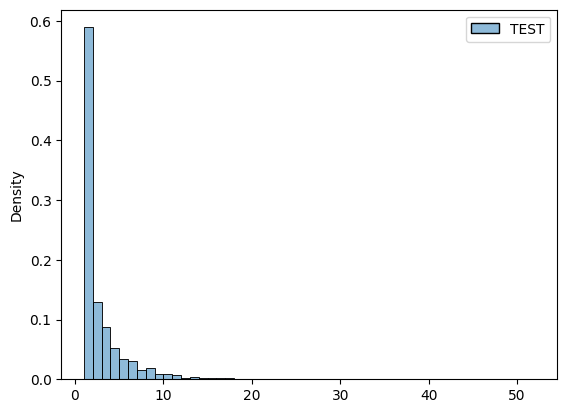

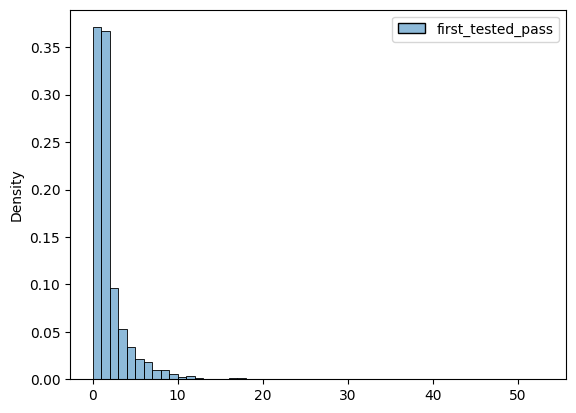

In [63]:
sns.histplot(pd.DataFrame(df.groupby(["unit_serial"])["TEST"].count().reset_index()),
              bins = 50, binwidth = 1, stat = "density")
plt.show()
plt.close()
sns.histplot(pd.DataFrame(df.groupby(["unit_serial"])["first_tested_pass"].count().reset_index()),
              bins = 50, binwidth = 1, stat = "density")
plt.show()
plt.close()

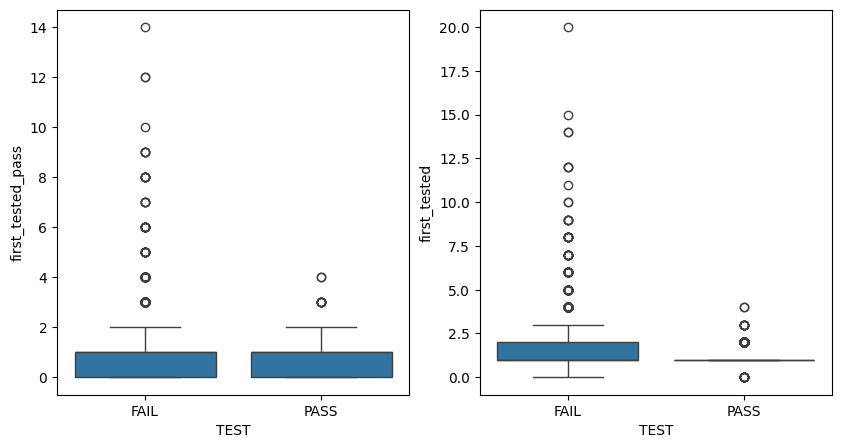

In [102]:
# Group by 'date' and 'first_tested_pass', and count the occurrences
df_grouped = df.groupby(["unit_serial", "TEST", "date_time"])[["first_tested_pass", "first_tested"]].count().reset_index()
df_grouped.head()

fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.boxplot(df_grouped, x = "TEST", y = "first_tested_pass")
plt.subplot(1,2,2)
sns.boxplot(df_grouped, x = "TEST", y = "first_tested")
plt.show()
plt.close()

<Axes: xlabel='first_tested_pass', ylabel='Density'>

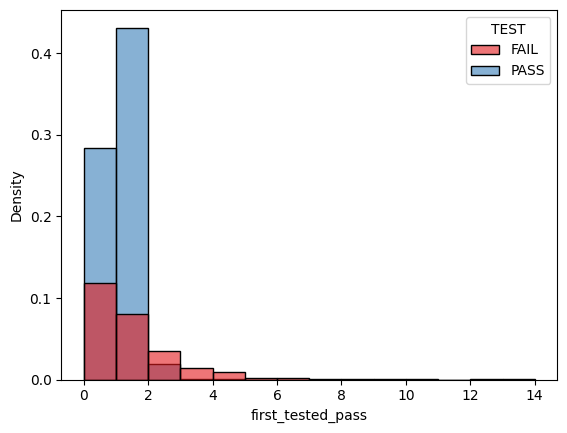

In [103]:
sns.histplot(df_grouped, x = "first_tested_pass",
              hue = "TEST",
              binwidth = 1,
              stat="density",
              alpha = 0.6,
              palette="Set1")

In [123]:
df_grouped.hvplot.hist("first_tested_pass", by = "TEST", subplots = True, width = 500, bins = 14)

:NdLayout   [TEST]
   :Histogram   [first_tested_pass]   (Count)

In [17]:
#drop duplicates
df_calibration["first_tested_pass"] = df_calibration["first_tested_pass"].round()
df_calibration = df_calibration.drop_duplicates(subset=["first_tested_pass"])